Universidad del Desarrollo

Magíster en Data Science


### Deep Learning
### Tarea 2: NLP

Autor: César Marín


### **Introducción**


Durante el desarrollo y revisión de los contenidos referentes a **Deep Learning** se estudiaron las diferentes arquitecturas de redes neuronales y las aplicaciones más adecuadas para cada una de ellas. Comenzando desde redes superficiales simples hasta llegar a modelos más complejos y que son capaces de resolver problemas de imágenes, sonidos o texto. En este caso y por interés personal se profundizará en las redes recurrentes **RNN**.

El dataset a utilizar fue descargado desde *Kaggle* mediante el link que se muestra debajo. Este conjunto de datos contiene una serie de tweets relacionados con la pandemia causada por el virus SARS-CoV-2 que fueron extraídos manualmente gracias a hasgtags y palabras relacionadas tales como #Coronavirus y #Covid_19. Este dataset contiene las siguientes columnas:

* UserName: Usuario (anonimizado)
* ScreenName: Nombre de pantalla del usuario (anonimizado)
* Location: Lugar, en caso de tener 
* TweetAt: Timestamp
* OriginalTweet: Tweet en su estado original (Incluye hashtags, menciones, URLs, etc)
* Sentiment: Variable a predecir

Link: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

La red que se muestra debajo corresponde a una recurrente de tipo Long-Short term memory. Lo innovador de este tipo de red se debe a la inclusión de una compuerta de olvido indicada como *f(t)* en el diagrama. La solución a este problema de análisis de sentimiento será basada en esta arquitectura por ser la más común y con resultados satisfactorios. La opción B que se podría utilizar en caso de no obtener un buen accuracy consiste en una de tipo CNN la cual es menos común, sin embargo es una solución presentanda en investigaciones recientes con buenos resultados y presentación incluso de arquitecturas híbridas con RNN.

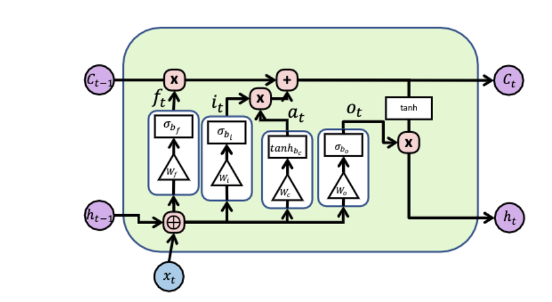
*Imagen extraída de clase 05*

In [1]:
# Importamos las librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from nltk.corpus import stopwords
import seaborn as sns
import string


from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping


Procedemos a cargar la data para luego proceder a explorarla y limpiarla. La data que se encuentra publicada viene en dos diferentes *.csv* que para esta asignación serán unidas para mayor comodidad. Luego se hará un train-test split.

In [2]:
df_1 = pd.read_csv('/Users/cesarmarin/Documents/Deep_Learning/Corona_NLP_train.csv', engine='python')
df_1.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df_2 = pd.read_csv('/Users/cesarmarin/Documents/Deep_Learning/Corona_NLP_test.csv', engine='python')
df_2.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Partimos explorando los tipos de datos que se tienen para cada columna y comprobar si existen datos nulos especialmente en las columna que serán utilizadas **OriginalTweet** y **Sentiment**

In [4]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Se puede observar que en ambos datasets sólo se tienen valores nulos en la columna de Location. Ninguna de las dos columnas a utilizar poseen valores nulos.

Hacemos el merge de los datasets tal como se comentó al principio del notebook.

In [6]:
frames = [df_1,df_2]
df = pd.concat(frames)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


Observamos la distribución inicial de las clases a predecir

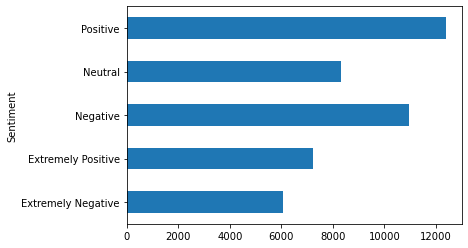

In [7]:
df.groupby('Sentiment').count()['UserName'].plot(kind="barh")
plt.show()

Debido a que el número de categorías es relativamente alto para este ejercicio de análisis de sentimiento y las posibilidades de confusión entre las Extremely y las positivas o negativas son muchas, se procede a convertir estas cinco categorías en sólo tres de la siguiente manera:

In [8]:
def etiqueta_nueva(categoria):
    if categoria == "Extremely Positive":
        return 2
    elif categoria == "Extremely Negative":
        return 0
    elif categoria == "Positive":
        return 2
    elif categoria == "Negative":
        return 0
    else:
        return 1

In [9]:
# Aplicamos la función definida
df.Sentiment = df.Sentiment.apply(lambda x : etiqueta_nueva(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


Se vuelve a graficar para tener una idea de la distribución de las clases a predecir

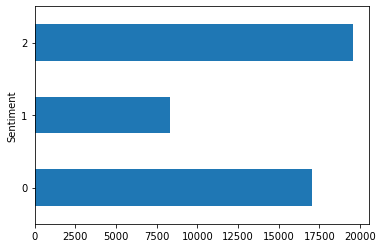

In [10]:
df.groupby('Sentiment').count()['UserName'].plot(kind="barh")
plt.show()

Otro de los aspectos que podemos revisar es el referido a la extensión de los tweets a revisar. A continuación se mostrará el número de caracterés y sus distribución de los tweets a analizar.

In [11]:
# Se hace un conteo
max_word_count = 0
count_char = []
for tweet in df['OriginalTweet']:
    count_char.append(len(tweet))

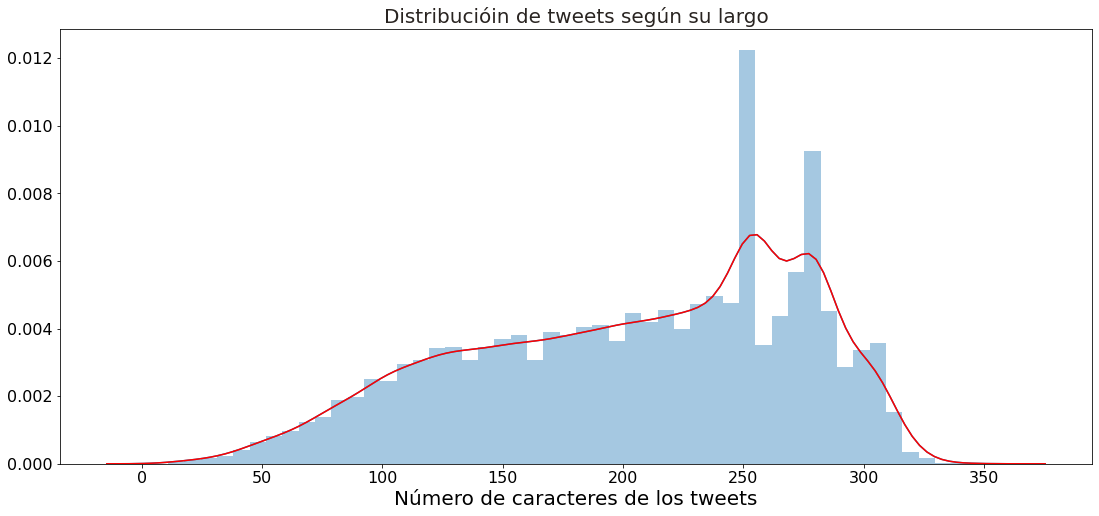

In [12]:
parameters = {'axes.labelsize': 20,
              'axes.titlesize': 20}
# Graficamos
plt.rcParams.update(parameters)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18.5, 8)
sns.distplot(count_char, ax=ax1);
sns.kdeplot(count_char, color='red', ax=ax1)
ax1.set_xlabel('Número de caracteres de los tweets');
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylabel("")
ax1.set_title("Distribucióin de tweets según su largo", color ="#292421")
plt.rcParams.update(parameters)

Se puede observar como los tweets presentan una distribución más o menos balanceada entro los 150 y 250 caracteres lo cual es esperado cuando se trata de esta red social. Hay un par de peaks alrededor de los 250 y 270.

### **Limpieza de Tweets**

Comenzamos haciendo una limpieza de la columna de tweets para posteriormente ser utilizada dentro de las redes a proponer; para esto definimos la siguiente función *limpieza_1_text* y convertimos todos los textos a letras **minúsculas**

In [13]:
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

In [14]:
def limpieza_1_text(text):
    text = re.sub(r'http\S+', " ", text)    # removemos los links/URLs
    text = re.sub(r'@\w+',' ',text)         # removemos las menciones a otras cuentas 
    text = re.sub(r'#\w+', ' ', text)       # removemos hashtags
    text = re.sub('r<.*?>',' ', text)       # removemos posibles tags exportados de código html
    return text

In [15]:
df['OriginalTweet_1'] = df['OriginalTweet'].apply(lambda x: limpieza_1_text(x))

Para remover los signos de puntuación aplicamos lo siguiente:

In [16]:
def remover_puntuacion(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
df['OriginalTweet_2'] = df['OriginalTweet_1'].apply(lambda x: remover_puntuacion(x))

Otra de las operaciones que se realizan para la limpieza de texto se refieren a la limpieza por stopwords. Al ser extraídos estos tweets desde cuentas angloparlantes se aplicará utilizando el diccionario para este idioma.

In [17]:
def remover_stop_words(text):
    stop_words = stopwords.words("english")
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    return text

In [18]:
df['OriginalTweet_3'] = df['OriginalTweet_2'].apply(lambda x: remover_stop_words(x))

Hacemos una limpieza de aquellas palabras de longitud menor a tres letras. Luego, usando de nuevo expresiones regulares se eliminan aquellos espaios que  multiple

In [19]:
def limpieza_palabras_espacios(df, label):
    df[label] = df[label].apply(lambda x: re.sub(r'\b\w{1,2}\b', " ", x))
    df[label] = df[label].apply(lambda x: re.sub(r"[ \t]{2,}", " ", x))
    return df

df = limpieza_palabras_espacios(df, 'OriginalTweet_3')

Procedemos a mostrar el dataset junto con estas columnas *OriginalTweet* que representan los pasos de las diferentes transformaciones realizadas a los textos. Esto nos sirve para corroborar los cambios y funciones aplicadas. Seguidamente nos quedaremos sólo con la columna agregada en el paso final **OriginalTweet_3**

In [20]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_1,OriginalTweet_2,OriginalTweet_3
0,3799,48751,London,16-03-2020,@menyrbie @phil_gahan @chrisitv https://t.co/i...,1,and and,and and,
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,2,advice talk to your neighbours family to excha...,advice talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia: woolworths to give elde...,2,coronavirus australia: woolworths to give elde...,coronavirus australia woolworths to give elder...,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,2,my food stock is not the only one which is emp...,my food stock is not the only one which is emp...,food stock one empty please dont panic enough ...
4,3803,48755,NaN,16-03-2020,"me, ready to go at supermarket during the #cov...",0,"me, ready to go at supermarket during the ou...",me ready to go at supermarket during the out...,ready supermarket outbreak paranoid food stock...
...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,meanwhile in a supermarket in israel -- people...,2,meanwhile in a supermarket in israel -- people...,meanwhile in a supermarket in israel people d...,meanwhile supermarket israel people dance sing...
3794,3795,48747,"Farmington, NM",16-03-2020,did you panic buy a lot of non-perishable item...,0,did you panic buy a lot of non-perishable item...,did you panic buy a lot of nonperishable items...,panic buy lot nonperishable items echo needs f...
3795,3796,48748,"Haverford, PA",16-03-2020,asst prof of economics @cconces was on @nbcphi...,1,asst prof of economics was on talking abou...,asst prof of economics was on talking abou...,asst prof economics talking recent research co...
3796,3797,48749,NaN,16-03-2020,gov need to do somethings instead of biar je r...,0,gov need to do somethings instead of biar je r...,gov need to do somethings instead of biar je r...,gov need somethings instead biar rakyat assume...


In [21]:
df_final = df[['OriginalTweet_3','Sentiment']]
df_final['tweet_limpio'] = df_final['OriginalTweet_3']

<ipython-input-21-92a7e10cb356>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['tweet_limpio'] = df_final['OriginalTweet_3']


Una vez aplicadas todas las operaciones de limpieza al dataset se procede a realizar la división en conjunto de datos de test y train. 

In [22]:
from sklearn.model_selection import train_test_split
X = df_final['tweet_limpio']
y = df_final['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [23]:
y_train_encoded = to_categorical(y_train, 3)
y_test_encoded = to_categorical(y_test, 3)

### Tokenización y Vocabulario

In [24]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

# Evaluamos la extensión del vocabulario obtenido a partir de la tokenización
vocab_length

37928

In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Imprimimos un ejemplo de tweet para cada uno de los conjunto de datos una vez aplicadas estas operaciones. Debemos obtener una lista de listas en donde cada palabra de cada tweet activará un índice de la tokenización realizada anteriormente.

In [26]:
print("Ejemplo de tweets")
print(X_train[3])
print(X_test[4])

Ejemplo de tweets
[243, 369, 5554, 2619, 72, 537, 114, 6, 4, 3016, 293]
[667, 131, 809, 1885, 325, 194]


Ahora se hace el padding de a esta lista de secuencias de tal manera que se alimente el modelo de un número constante de entradas. Debido a que los tweets tienen un tamaño limitado de caracteres se escogerá un maxlen de 40 palabras. Así cubrimos la longitid de todos los tweets.

In [27]:
X_train = pad_sequences(X_train, maxlen=40, padding='post')
X_test = pad_sequences(X_test, maxlen=40, padding='post')

# Comprobamos con las dimensiones del train y test
print(X_test.shape)
print(X_train.shape)

(8991, 40)
(35964, 40)


Se revisaron diferentes artículos para poder escoger un modelo de redes neuronales adecuado para la su solución. Los más eficientes para el análisis de sentimiento. La opción **A** se refiere a la utilización de una red recurrente de tipo LSTM, esta no sólo es una de las más usadas sino que ofrece resultados satisfactorios para este problema de sentimiento multiclase. La opción **B** que se plantea es el uso de una red convolucional las cuales si bien son más utilizadas con imágenes también existen papers y soluciones que las aplican de manera satisfactoria.

* Se seguirá utilizando Tensorflow/Keras para la construcción de los modelos.
* La arquitectura a utilizar será la siguiente: 
    * Embedding Layer con un vocab_lenght de 10000.
    * Long-Short term memory layer de dimensión 200 con un input_lenght de 40.
    * Conexión a dos capas de redes densas de 32 y 16 neuronas con función de activación RELU 
    * Un output layer de activación softmax con un output de 3 categorías
    * Se utilizarán como función de pérdida *categorical_crossentropy*, como optimizador *Adam* y métrica *Accuracy*
* La opción B la cual no se desarrollará en esta entrega se refiere a una CNN. Una de las propuestas se basa en la arquitectura encontrada en: https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7

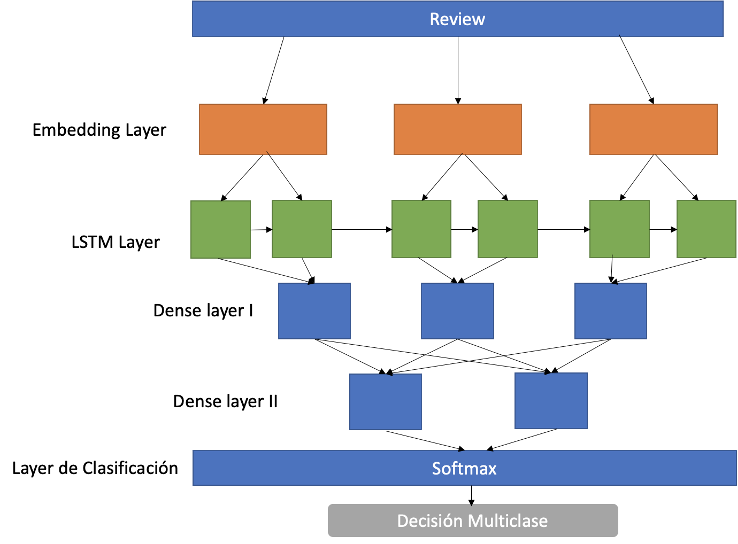

Aplicamos esta red usando Tensorflow/Keras

In [28]:
vocab_length = 10000
modelo_LSTM = Sequential()
# Capa de embedding
modelo_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=40, mask_zero=True))
# Capa LSTM
modelo_LSTM.add(layers.LSTM(200))
# Capas densas
modelo_LSTM.add(layers.Dense(32, activation="relu"))
modelo_LSTM.add(layers.Dense(16, activation="relu"))
# Capa Softmax
modelo_LSTM.add(layers.Dense(3, activation='softmax'))
# Compilación
modelo_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelo_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 200)               186400    
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 513,411
Trainable params: 513,411
Non-trainable params: 0
_________________________________________________________________
None


Observamos de manera compacta una arquitectura de esta red a utilizar. Los parámetros a entrenar suman un total de 521443.

In [29]:
modelo_fit = modelo_LSTM.fit(X_train,
                         y_train_encoded,
                         epochs=10,
                         batch_size=100,
                         verbose=1,
                        )

Epoch 1/10
360/360 [==============================] - 32s 79ms/step - loss: 0.7205 - accuracy: 0.6745
Epoch 2/10
360/360 [==============================] - 29s 81ms/step - loss: 0.3734 - accuracy: 0.8747
Epoch 3/10
360/360 [==============================] - 29s 81ms/step - loss: 0.2925 - accuracy: 0.9078
Epoch 4/10
360/360 [==============================] - 30s 83ms/step - loss: 0.2503 - accuracy: 0.9224
Epoch 5/10
360/360 [==============================] - 30s 83ms/step - loss: 0.2275 - accuracy: 0.9309
Epoch 6/10
360/360 [==============================] - 31s 86ms/step - loss: 0.2053 - accuracy: 0.9363
Epoch 7/10
360/360 [==============================] - 30s 84ms/step - loss: 0.1861 - accuracy: 0.9426
Epoch 8/10
360/360 [==============================] - 31s 85ms/step - loss: 0.1626 - accuracy: 0.9475
Epoch 9/10
360/360 [==============================] - 30s 82ms/step - loss: 0.1420 - accuracy: 0.9532
Epoch 10/10
360/360 [==============================] - 31s 86ms/step - loss: 0.122

In [42]:
predicted = modelo_LSTM.predict(X_test)
y_pred = predicted.argmax(axis=-1)

Se evalúa el modelo con la data de test.

In [31]:
_, accuracy = modelo_LSTM.evaluate(X_test, y_test_encoded)
print('Accuracy: %.2f' % (accuracy*100))

281/281 [==============================] - 5s 14ms/step - loss: 0.6984 - accuracy: 0.8424
Accuracy: 84.24


**Comentarios de resulatados:** Claramente existe un overfitting del modelo accuracy muestra un incremento sostenido mientras que al probar la solución con la data de test esta presenta un desempeño 10 puntos por debajo. Es decir, si bien el resultado superando el 84% es bueno, son necesarias otras acciones para mejorar las limitaciones que este presenta.

Hacemos una evaluación más de cerca de este modelo con una matriz de confusión.

Text(0.5, 15.0, 'Prediction')

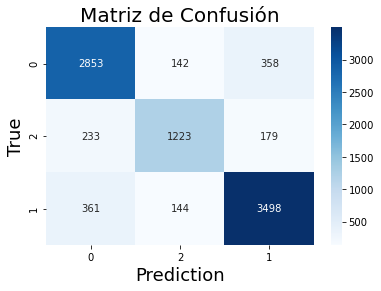

In [43]:
## Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues)
ax.set(xticklabels=list(y_test.unique()), yticklabels=list(y_test.unique()), title="Matriz de Confusión")
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_ylabel("True", fontsize=18)
ax.set_xlabel("Prediction", fontsize=18)

**Comentarios de resultados:** Se puede observar en esta matriz de confusión que se cometieron fallos en las tres clases estudiados. La clase 2 perteneciente a aquellos comentarios positivos fue el que presento menor porcentaje de aciertos. Sin embargo, esta diferencia no parece alarmante.

### Early Stopping
En la última clase referida a generalidades para la optimización de las redes neuronales se revisó el Early Stopping como una de las estrategias efectivas para evitar el **overfitting** y así mejorar el rendimiento del output para la data de test y obtener un resultado más estable. Es por ello que se intentará con este método manteniendo la misma estructura de la red.

In [33]:
vocab_length = 10000
modelo_LSTM2 = Sequential()
# Capa de embedding
modelo_LSTM2.add(layers.Embedding(vocab_length, output_dim=32, input_length=40, mask_zero=True))
# Capa LSTM
modelo_LSTM2.add(layers.LSTM(200))
# Capas densas
modelo_LSTM2.add(layers.Dense(32, activation="relu"))
modelo_LSTM2.add(layers.Dense(16, activation="relu"))
# Capa Softmax
modelo_LSTM2.add(layers.Dense(3, activation='softmax'))
# Compilación
modelo_LSTM2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelo_LSTM2.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 32)            320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 513,411
Trainable params: 513,411
Non-trainable params: 0
_________________________________________________________________
None


La cantidad de parámetros permanece constante debido a que vamos a repetir la estructura con un early stopping como callback tal como se muestra debajo:

In [34]:
early = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
history = modelo_LSTM2.fit(X_train,
                         y_train_encoded,
                         validation_data=(X_test, y_test_encoded),
                         epochs=15,
                         batch_size=100,
                         verbose=1,
                         callbacks=[early]
                        )

Epoch 1/15
360/360 [==============================] - 37s 90ms/step - loss: 0.7197 - accuracy: 0.6766 - val_loss: 0.5034 - val_accuracy: 0.8140
Epoch 2/15
360/360 [==============================] - 34s 93ms/step - loss: 0.3783 - accuracy: 0.8721 - val_loss: 0.4315 - val_accuracy: 0.8504
Epoch 3/15
360/360 [==============================] - 35s 97ms/step - loss: 0.2904 - accuracy: 0.9076 - val_loss: 0.4491 - val_accuracy: 0.8505
Epoch 4/15
360/360 [==============================] - 32s 90ms/step - loss: 0.2501 - accuracy: 0.9211 - val_loss: 0.4509 - val_accuracy: 0.8559
Epoch 5/15
360/360 [==============================] - 30s 84ms/step - loss: 0.2251 - accuracy: 0.9305 - val_loss: 0.5211 - val_accuracy: 0.8465
Epoch 6/15
360/360 [==============================] - 36s 101ms/step - loss: 0.1971 - accuracy: 0.9387 - val_loss: 0.5118 - val_accuracy: 0.8524
Epoch 7/15
360/360 [==============================] - 41s 113ms/step - loss: 0.1735 - accuracy: 0.9448 - val_loss: 0.5682 - val_accurac

**Comentarios de resultados:** El output de este proceso que incluyó el *early stopping* demuestra como el accuracy para el set de validación practiamente se mantiene constante luego de la tercera época mientras que para el set de datos de entrenamiento el accuracy sigue aumentando. Por lo tanto, va generándose un overfitting importante del modelo. Además, la mejora en el desempeño del modelo aumenta en un 1.5%. A continuación, se presenta la matriz de confusión para obervar y comparar con los resultados anteriores sin *ES*

In [35]:
predicted_1 = modelo_LSTM2.predict(X_test)
y_pred_1 = predicted_1.argmax(axis=-1)

Text(0.5, 15.0, 'Prediction')

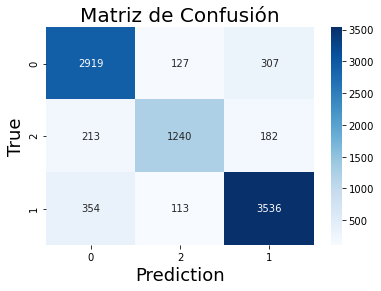

In [36]:
## Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_1)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues)
ax.set(xticklabels=list(y_test.unique()), yticklabels=list(y_test.unique()), title="Matriz de Confusión")
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_ylabel("True", fontsize=18)
ax.set_xlabel("Prediction", fontsize=18)

Esto nos indica como hubo una mejora en la predicción de todas las clases. El Early Stopping benefició de manera transversal el desempeño del modelo aunque se mantiene la clase 2 como la de mayor cantidad de fallos.

### **Conclusiones**

* En primer lugar, se observó como este tipo de red neuronal recurrente escogida (LSTM) obtuvo resultados satisfactorios e incluso por encima del 85% al utilizar early stopping. Esto deja claro que el enfoque utilizado fue adeucado.

* En la matriz de confusión del primer modelo se comprueba que la clase en donde se tiene más problemas en la predicción es la **2** que se refiere al sentimiento positivo. Es la clase con menor cantidad de datos y contiene el mayor porcentaje de fallos. Esto mismo ocurre durante el *ES* sólo que acertando más predicciones para esta clase.

* Si bien el primer modelo ofreció unos resultados satisfactorios desde el punto de vista de accuracy, se decidió poner en ejecución un early stopping para controlar el overfitting y mejorar el desempeño. Este objetivo fue también logrado.

* Como trabajo futuro se plantea hacer la prueba con las estructuras novedosas de CNN para clasificación de sentimiento y poder compararla con esta solución así como también probar con otras estrategias de manejo y mejora del overfitting tal como el dropout.